**Table of contents**<a id='toc0_'></a>    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## Data preprocessing

> Experiments with a preprocessing pipeline.

### Setup


In [37]:
#| default_exp preprocessing
#| export
import copy
import enum
import json
import os
import pathlib
import random

from joblib import delayed, Parallel
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from torchvision.transforms import transforms
import torchvision.transforms.functional as TF

from csgo_clips_autotrim.segmentation.utils import EliminationEventsDataset, box_to_mask, show_mask

In [3]:
DATA_DIR = pathlib.Path('/data/autotrim/datasets/')
FRAMES_DATA_DIR = DATA_DIR / 'frames'
COCO_DATASET_DIR = DATA_DIR / 'frames-annotated-coco'
ANNOTATIONS_PATH = COCO_DATASET_DIR / 'result.json'
dataset = EliminationEventsDataset(annotation_file_path=ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


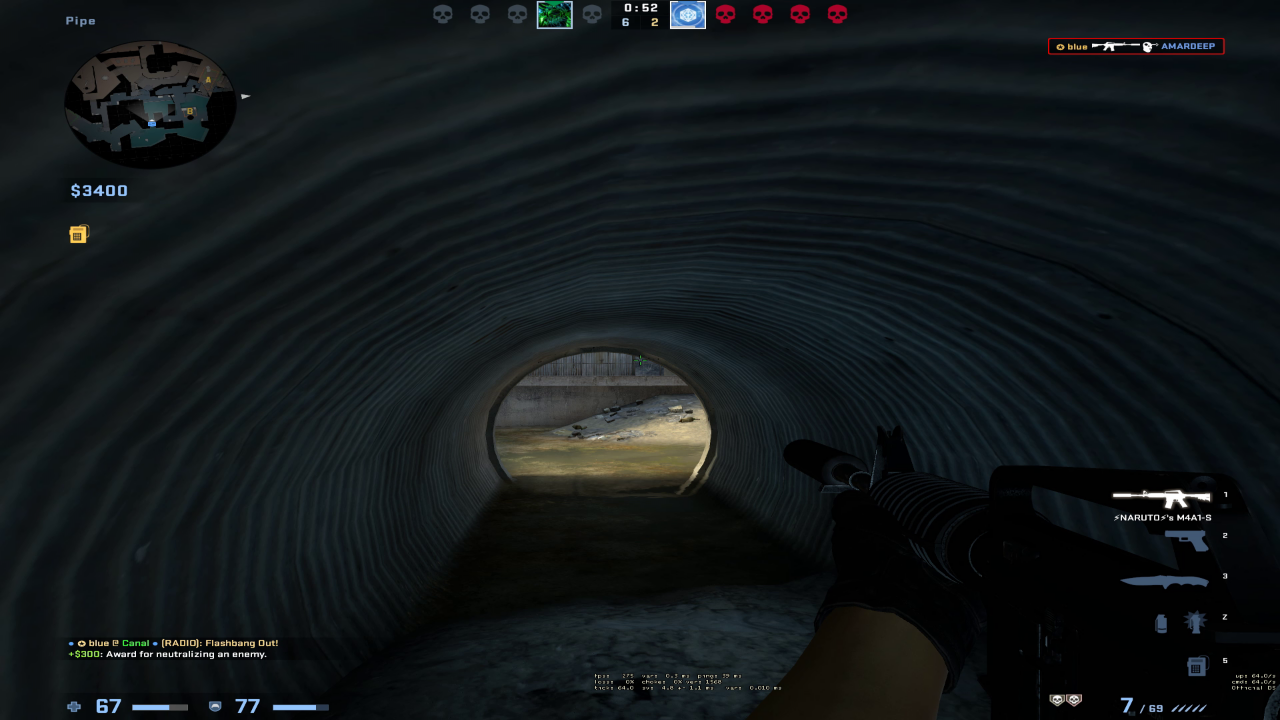

In [4]:
test_frame, annotations = random.choice(dataset)

test_frame

### Preprocessing options

1. Crop (top right)
2. Thresholding
3. Edge detection

In [5]:
# |export
# Define the custom transformation for top right quadrant
class TopRightQuadrant(object):
    def __call__(self, entry):
        img, targets = entry
        width, height = img.size
        img = img.crop((width // 2, 0, width, height // 2))

        # Adjust target bounding box coordinates
        for box in targets['boxes']:
            # xmin, ymin, xmax, ymax = box
            # # Only need to adjust the x coordinates.
            box[[0, 2]] -= width / 2

        return img, targets

class ImageVisTransform:
    def __init__(self, sharpness=2):
        self.sharpness = sharpness
    
    def __call__(self, x):
        img, targets = x
        return TF.autocontrast(TF.adjust_sharpness(img, self.sharpness)), targets

class ImageToTensor:
    def __call__(self, x):
        img, targets = x
        return TF.to_tensor(img), targets

class Grayscale:
    def __call__(self, x):
        img, targets = x
        return TF.to_grayscale(img), targets

In [6]:
# Define the preprocessing transformations
preprocess = transforms.Compose([
    TopRightQuadrant(),  # Use the top right quadrant only
    ImageVisTransform(1)
])

In [7]:
dataset = EliminationEventsDataset(annotation_file_path=ANNOTATIONS_PATH, transforms=preprocess)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


5


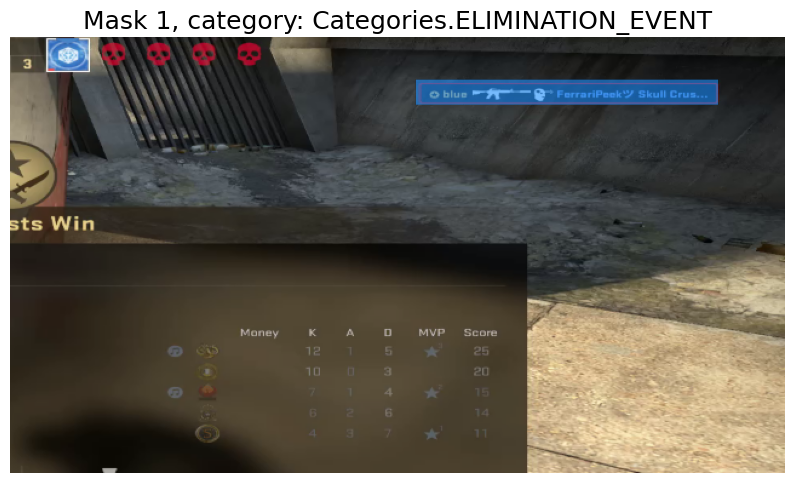

In [8]:
sample = random.choice(dataset)
img, anns = sample

print(len(anns))

for i in range(len(anns['boxes'])):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    mask = box_to_mask(anns['boxes'][i], img.height, img.width)
    show_mask(mask, plt.gca())
    category = EliminationEventsDataset.Categories(anns['labels'][i].numpy())
    plt.title(f"Mask {i+1}, category: {category}", fontsize=18)
    plt.axis('off')
    plt.show()  

### Preprocessing config

In [45]:
class TransformOp(enum.Flag):
    CROP_TOP_RIGHT_QUADRANT = enum.auto()
    GRAYSCALE = enum.auto()

['TransformOp.CROP_TOP_RIGHT_QUADRANT', 'TransformOp.GRAYSCALE']

### COCO transformations
> Transform COCO datasets with these transforms.

In [50]:
# |export
def transform_coco(input_dataset_path: os.PathLike, output_dataset_path: os.PathLike, transform_op: TransformOp):
    """Transform the given COCO format dataset.
    1. Crop to the top right quadrant of the image.
    2. Convert to grayscale.

    NOTE: Assumes that all images are of the same dimensions.

    Args:
        coco_dataset_path (str)
        output_path (str)
    """
    input_dataset_path = pathlib.Path(input_dataset_path)
    coco_json_path = input_dataset_path / 'result.json'
    image_path = input_dataset_path / 'images'

    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)
    
    image_sample = random.choice(coco_data['images'])

    original_img_h = image_sample['height']
    original_img_w = image_sample['width']
    new_img_h = original_img_h // 2
    new_img_w = original_img_w // 2

    new_coco_data = copy.deepcopy(coco_data)

    convert_grayscale = transform_op & TransformOp.GRAYSCALE
    crop_quad = transform_op & TransformOp.CROP_TOP_RIGHT_QUADRANT

    # Step 1: Transform bboxes if needed.
    if crop_quad:
        new_coco_data['annotations'] = list(filter(lambda x: x['category_id'] == 1, new_coco_data['annotations']))

        for annotation in new_coco_data['annotations']:
            bbox = annotation['bbox']
            x_min, y_min, w, h = bbox
            x_min -= new_img_w

            # Filter out bboxes which are not in the top right quadrant.
            if x_min >= 0 and y_min < new_img_h:
                annotation['bbox'] = [x_min, y_min, w, h]
            else:
                annotation['bbox'] = []
    
    output_dataset_path = pathlib.Path(output_dataset_path)
    output_image_path = output_dataset_path / 'images'
    output_image_path.mkdir(parents=True, exist_ok=True)
    
    # Step 2: Process images.
    def process_image(file_name: str):
        with open(image_path / file_name, 'rb') as f:
            img = Image.open(f)

            if crop_quad:
                img = img.crop((new_img_w, 0, original_img_w, new_img_h))

            if convert_grayscale:
                img = ImageOps.grayscale(img)

            output_image_file_path = output_image_path / file_name
            output_image_file_path.parent.mkdir(parents=True, exist_ok=True)
            img.save(output_image_file_path)
    
    files_to_process = []

    for image in new_coco_data['images']:
        image['height'] = new_img_h
        image['width'] = new_img_w

        files_to_process.append(image['file_name'])
    
    Parallel(n_jobs=8)(delayed(process_image)(file) for file in files_to_process)
    
    with open(output_dataset_path / 'result.json', 'w') as f:
        json.dump(new_coco_data, f)

In [51]:
transform_coco('/data/autotrim/datasets/frames-annotated-coco-local',
               '/data/autotrim/datasets/frames-annotated-coco-local-rgb', TransformOp.CROP_TOP_RIGHT_QUADRANT)